In [1]:
import sklearn
import numpy as np
from numpy import ma
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression

In [2]:
names =['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df = pd.read_csv('train.csv',header=None,sep=",",names=names, encoding = "ISO-8859-1")

df['toxic_score'] = df[['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
#drop unnecessary columns
df = df.drop(['id', 'toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate'], axis=1)
#drop first row
df.drop(df.index[:1], inplace=True)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
bad_words = []
negative_file = open("negative-words.txt", "r")
for line in negative_file:
    bad_words.append(line.strip("\n"))
negative_file.close()
profanity_file = open("profanity-words.txt", "r")
for line in profanity_file:
    if (line.strip("\n") not in bad_words):
        bad_words.append(line.strip("\n"))
profanity_file.close()

In [4]:
# making an even data set since ~16,000 are labeled as toxic
# others of the 150,000 are labeled as non-toxic, so data-set is highly unbalanced
# also making data set size 15000 since our laptops for some reason can't handle high data sizes
data = df.values

X = data[:,0].reshape((159571,1))
Y = data[:,1].reshape((159571,1))

toxic_count = 0
not_toxic_count = 0
val_toxic = 0
val_not_toxic = 0

X_tr = []
Y_tr = []
X_val = []
Y_val = []

data_size = 15000

for index in range(0,159571):
    if ((int(Y[index][0]) == 1 and toxic_count < 0.5 * data_size) or 
        (int(Y[index][0]) == 0 and not_toxic_count < 0.5 * data_size)):
        Y_tr.append(int(Y[index][0]))
        X_tr.append(X[index][0])
        if (int(Y[index][0]) == 1):
            toxic_count += 1
        else:
            not_toxic_count += 1
    if toxic_count == 0.5 * data_size and not_toxic_count == 0.5 * data_size:
        if ((int(Y[index][0]) == 1 and val_toxic < 0.5 * data_size) or 
            (int(Y[index][0]) == 0 and val_not_toxic < 0.5 * data_size)):
            Y_val.append(int(Y[index][0]))
            X_val.append(X[index][0])
            if (int(Y[index][0]) == 1):
                val_toxic += 1
            else:
                val_not_toxic += 1
        if val_toxic + val_not_toxic == data_size:
            break

# X_tr = np.array(X_tr).reshape((15000, 1))
Y_train = np.array(Y_tr).reshape((data_size, 1))
Y_test = np.array(Y_val).reshape((data_size, 1))


cv = sklearn.feature_extraction.text.CountVectorizer(vocabulary=bad_words)
X_train = cv.fit_transform(X_tr).toarray()
X_test = cv.fit_transform(X_val).toarray()

print(X_train, X_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
#Preprocessing
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [6]:
def logreg_model(c, penalty="l2"):
    solver = 'saga'
    if penalty == "l2":
        solver = 'sag'
    logreg = LogisticRegression(penalty=penalty, C=c, solver=solver)
    
    logreg.fit(X_train, Y_train.ravel())
    
    Yhat_train = logreg.predict(X_train)
    acc_train = logreg.score(X_train, Y_train.ravel())
    
    Yhat_test = logreg.predict(X_test)
    acc_test = logreg.score(X_test, Y_test.ravel())
    
    print("Weights:", logreg.coef_)
    print("Intercept:", logreg.intercept_)
    
    return acc_train, acc_test

Logistic Regression:


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.03987014 ... 0.0071711  0.         0.03935088]]
Intercept: [0.13759802]
Training accuracy: 0.7840666666666667
Test accuracy: 0.7188666666666667

Logistic Regression with Lasso
C: 0.0001
Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [0.00152387]
Training accuracy: 0.5
Testing accuracy: 0.5

C: 0.001
Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [-0.00082989]
Training accuracy: 0.5
Testing accuracy: 0.5

C: 0.01


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [0.04564727]
Training accuracy: 0.7172
Testing accuracy: 0.6849333333333333

C: 0.1


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.03101044 ... 0.00508779 0.         0.02967071]]
Intercept: [0.09897877]
Training accuracy: 0.7816
Testing accuracy: 0.7174

C: 1


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.0384848  ... 0.00705164 0.         0.03809295]]
Intercept: [0.10190829]
Training accuracy: 0.7826666666666666
Testing accuracy: 0.7169333333333333

C: 10


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.03919906 ... 0.00726248 0.         0.03884383]]
Intercept: [0.10221531]
Training accuracy: 0.7827333333333333
Testing accuracy: 0.7162666666666667

C: 100


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.0396084  ... 0.00736603 0.         0.03895804]]
Intercept: [0.10243739]
Training accuracy: 0.7830666666666667
Testing accuracy: 0.7162666666666667


Logistic Regression with Ridge
C: 0.0001
Weights: [[0.         0.         0.00611452 ... 0.0026352  0.         0.00533911]]
Intercept: [0.00414918]
Training accuracy: 0.757
Testing accuracy: 0.7098

C: 0.001


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.02328382 ... 0.00639566 0.         0.02327437]]
Intercept: [0.06669766]
Training accuracy: 0.7794666666666666
Testing accuracy: 0.7138666666666666

C: 0.01


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.03717896 ... 0.00704333 0.         0.03686493]]
Intercept: [0.12708641]
Training accuracy: 0.7837333333333333
Testing accuracy: 0.718

C: 0.1


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.03949329 ... 0.00733965 0.         0.03856055]]
Intercept: [0.13670172]
Training accuracy: 0.7840666666666667
Testing accuracy: 0.7188666666666667

C: 1


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.03943734 ... 0.00729667 0.         0.03877244]]
Intercept: [0.13807817]
Training accuracy: 0.784
Testing accuracy: 0.7188666666666667

C: 10


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.03975924 ... 0.00727137 0.         0.03916455]]
Intercept: [0.13839111]
Training accuracy: 0.784
Testing accuracy: 0.719

C: 100


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.03988147 ... 0.0072482  0.         0.03860369]]
Intercept: [0.13865024]
Training accuracy: 0.784
Testing accuracy: 0.7189333333333333




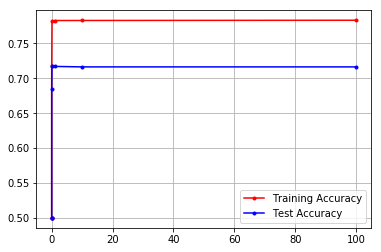

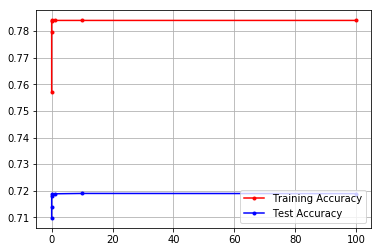

In [7]:
# regular logistic regression

print("Logistic Regression:")
acc_train, acc_test = logreg_model(c=100000000)
print("Training accuracy:", acc_train)
print("Test accuracy:", acc_test)
print()

regularization = {
    'l1': 'Lasso',
    'l2': 'Ridge'
}

c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for key in regularization:
    print("Logistic Regression with " + regularization[key])
    acc_training = []
    acc_testing = []
    for val in c_values:
        print("C:", val)
        acc_tr, acc_te = logreg_model(c=val, penalty=key)
        acc_training.append(acc_tr)
        acc_testing.append(acc_te)
        print('Training accuracy:', acc_tr)
        print('Testing accuracy:', acc_te)
        print()
    plt.figure()
    plt.plot(c_values, acc_training, 'r.-') 
    plt.plot(c_values, acc_testing,'b.-') 
    plt.grid()
    plt.legend(['Training Accuracy', 'Test Accuracy'], loc='lower right')
    print()

# Normalizing the Data

In [5]:
X_train_norm = cv.fit_transform(X_tr).toarray()
X_test_norm = cv.fit_transform(X_val).toarray()

print(X_train_norm, X_test_norm)

#Preprocessing - Normalization
X_train_norm = preprocessing.normalize(X_train_norm)
X_test_norm = preprocessing.normalize(X_test_norm)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [6]:
def logreg_model_norm(c, penalty="l2"):
    solver = 'saga'
    if penalty == "l2":
        solver = 'sag'
    logreg_norm = LogisticRegression(penalty=penalty, C=c, solver=solver)
    
    logreg_norm.fit(X_train_norm, Y_train.ravel())
    
    Yhat_train = logreg_norm.predict(X_train_norm)
    acc_train_norm = logreg_norm.score(X_train_norm, Y_train.ravel())
    
    Yhat_test = logreg_norm.predict(X_test_norm)
    acc_test_norm = logreg_norm.score(X_test_norm, Y_test.ravel())
    
    print("Weights:", logreg_norm.coef_)
    print("Intercept:", logreg_norm.intercept_)
    
    return acc_train_norm, acc_test_norm

In [8]:
print("Logistic Regression - Normalized Data:")
acc_train_norm, acc_test_norm = logreg_model_norm(c=100000000)
print("Training accuracy:", acc_train_norm)
print("Test accuracy:", acc_test_norm)
print()


Logistic Regression - Normalized Data:


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[ 0.00000000e+00  0.00000000e+00  5.17791373e+00 ... -4.56399674e-03
   0.00000000e+00  4.30846908e+00]]
Intercept: [-1.60136739]
Training accuracy: 0.9086666666666666
Test accuracy: 0.8520666666666666



Logistic Regression (Normalized Data) with Lasso
C: 0.0001
Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [-0.55237483]
Training accuracy: 0.5
Testing accuracy: 0.5

C: 0.001
Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [-0.00603435]
Training accuracy: 0.5
Testing accuracy: 0.5

C: 0.01
Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [-0.18482801]
Training accuracy: 0.6560666666666667
Testing accuracy: 0.6537333333333334

C: 0.1
Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [-0.76051619]
Training accuracy: 0.8127333333333333
Testing accuracy: 0.8118

C: 1
Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [-1.33082994]
Training accuracy: 0.8704
Testing accuracy: 0.8582666666666666

C: 10


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.84752481 ... 0.         0.         0.        ]]
Intercept: [-1.57754739]
Training accuracy: 0.9046666666666666
Testing accuracy: 0.8595333333333334

C: 100


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         3.86241067 ... 0.         0.         3.38417503]]
Intercept: [-1.59897675]
Training accuracy: 0.9084666666666666
Testing accuracy: 0.8526


Logistic Regression (Normalized Data) with Ridge
C: 0.0001
Weights: [[ 0.00000000e+00  0.00000000e+00  6.00934522e-05 ... -8.83911756e-06
   0.00000000e+00  3.17127574e-05]]
Intercept: [-0.00762041]
Training accuracy: 0.6820666666666667
Testing accuracy: 0.6801333333333334

C: 0.001
Weights: [[ 0.          0.          0.00059912 ... -0.0001037   0.
   0.00030239]]
Intercept: [-0.03908256]
Training accuracy: 0.7360666666666666
Testing accuracy: 0.7402666666666666

C: 0.01
Weights: [[ 0.          0.          0.00575942 ... -0.00179286  0.
   0.0023382 ]]
Intercept: [-0.22810364]
Training accuracy: 0.7720666666666667
Testing accuracy: 0.7765333333333333

C: 0.1
Weights: [[ 0.          0.          0.04890576 ... -0.02058101  0.
   0.01425064]]
Intercept: [-0.65140514]
Training accuracy: 0.8334666666666667
Testing accura

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[ 0.          0.          3.08581488 ... -0.02886421  0.
   2.43117681]]
Intercept: [-1.57902964]
Training accuracy: 0.9064666666666666
Testing accuracy: 0.8554




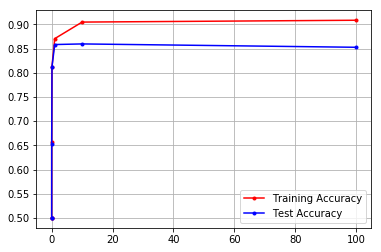

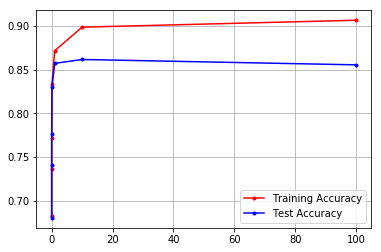

In [7]:
regularization = {
    'l1': 'Lasso',
    'l2': 'Ridge'
}

c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for key in regularization:
    print("Logistic Regression (Normalized Data) with " + regularization[key])
    acc_training_norm = []
    acc_testing_norm = []
    for val in c_values:
        print("C:", val)
        acc_tr_norm, acc_te_norm = logreg_model_norm(c=val, penalty=key)
        acc_training_norm.append(acc_tr_norm)
        acc_testing_norm.append(acc_te_norm)
        print('Training accuracy:', acc_tr_norm)
        print('Testing accuracy:', acc_te_norm)
        print()
    plt.figure()
    plt.plot(c_values, acc_training_norm, 'r.-') 
    plt.plot(c_values, acc_testing_norm,'b.-') 
    plt.grid()
    plt.legend(['Training Accuracy', 'Test Accuracy'], loc='lower right')
    print()

# Polynomial Features of Data

In [ ]:
X_train_pf = cv.fit_transform(X_tr).toarray()
X_test_pf = cv.fit_transform(X_val).toarray()

#Preprocessing again
poly = preprocessing.PolynomialFeatures(2)
X_train_pf = poly.fit_transform(X_train_pf)
X_test_pf = poly.fit_transform(X_test_pf)

In [ ]:
def logreg_model_pf(c, penalty="l2"):
    solver = 'saga'
    if penalty == "l2":
        solver = 'sag'
    logreg_pf = LogisticRegression(penalty=penalty, C=c, solver=solver)
    
    logreg_pf.fit(X_train_pf, Y_train.ravel())
    
    Yhat_train = logreg_pf.predict(X_train_pf)
    acc_train_pf = logreg_pf.score(X_train_pf, Y_train.ravel())
    
    Yhat_test = logreg_pf.predict(X_test_pf)
    acc_test_pf = logreg_pf.score(X_test_pf, Y_test.ravel())
    
    print("Weights:", logreg_pf.coef_)
    print("Intercept:", logreg_pf.intercept_)
    
    return acc_train_pf, acc_test_pf

In [ ]:
print("Logistic Regression - Power-Transformed Data:")
acc_train_pf, acc_test_pf = logreg_model_pf(c=100000000)
print("Training accuracy:", acc_train_pf)
print("Test accuracy:", acc_test_pf)
print()

#This overkilled the kernel hence there are no results

# Min Max Feature Transformation

In [8]:
X_train_mm = cv.fit_transform(X_tr).toarray()
X_test_mm = cv.fit_transform(X_val).toarray()

#Preprocessing - Min Max - center it between 0 and 1
X_train_mm = preprocessing.minmax_scale(X_train_mm, feature_range=(0, 1))
X_test_mm = preprocessing.minmax_scale(X_test_mm, feature_range=(0, 1))

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [9]:
def logreg_model_mm(c, penalty="l2"):
    solver = 'saga'
    if penalty == "l2":
        solver = 'sag'
    logreg_mm = LogisticRegression(penalty=penalty, C=c, solver=solver)
    
    logreg_mm.fit(X_train_mm, Y_train.ravel())
    
    Yhat_train = logreg_mm.predict(X_train_mm)
    acc_train_mm = logreg_mm.score(X_train_mm, Y_train.ravel())
    
    Yhat_test = logreg_mm.predict(X_test_mm)
    acc_test_mm = logreg_mm.score(X_test_mm, Y_test.ravel())
    
    print("Weights:", logreg_mm.coef_)
    print("Intercept:", logreg_mm.intercept_)
    
    return acc_train_mm, acc_test_mm

In [9]:
print("Logistic Regression - Min-Max Data:")
acc_train_mm, acc_test_mm = logreg_model_mm(c=100000000)
print("Training accuracy:", acc_train_mm)
print("Test accuracy:", acc_test_mm)
print()


Logistic Regression - Min-Max Data:


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         3.11953524 ... 0.2852822  0.         3.03205108]]
Intercept: [-0.33305111]
Training accuracy: 0.7779333333333334
Test accuracy: 0.709



Logistic Regression (Min-Max Scaled Data) with Lasso
C: 0.0001
Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [0.13666187]
Training accuracy: 0.5
Testing accuracy: 0.5

C: 0.001
Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [-0.04140431]
Training accuracy: 0.5
Testing accuracy: 0.5

C: 0.01
Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [-0.00065473]
Training accuracy: 0.5
Testing accuracy: 0.5

C: 0.1
Weights: [[0. 0. 0. ... 0. 0. 0.]]
Intercept: [-0.01923751]
Training accuracy: 0.5642
Testing accuracy: 0.5440666666666667

C: 1


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         0.14253948 ... 0.         0.         0.26570683]]
Intercept: [-0.23500213]
Training accuracy: 0.7307333333333333
Testing accuracy: 0.6866666666666666

C: 10


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         2.59637982 ... 0.28872218 0.         2.42751573]]
Intercept: [-0.32274843]
Training accuracy: 0.7757333333333334
Testing accuracy: 0.7088666666666666

C: 100


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         3.08008659 ... 0.28084154 0.         2.93545675]]
Intercept: [-0.33254905]
Training accuracy: 0.7777333333333334
Testing accuracy: 0.7088


Logistic Regression (Min-Max Scaled Data) with Ridge
C: 0.0001
Weights: [[0.         0.         0.00014991 ... 0.00010001 0.         0.00010009]]
Intercept: [-0.00012097]
Training accuracy: 0.6772666666666667
Testing accuracy: 0.6448666666666667

C: 0.001
Weights: [[0.         0.         0.00149141 ... 0.00100065 0.         0.00100213]]
Intercept: [-0.0006231]
Training accuracy: 0.7022666666666667
Testing accuracy: 0.6776

C: 0.01
Weights: [[0.         0.         0.01420528 ... 0.0100378  0.         0.01019143]]
Intercept: [-0.00583263]
Training accuracy: 0.703
Testing accuracy: 0.6786

C: 0.1
Weights: [[0.         0.         0.10832979 ... 0.09053024 0.         0.10786884]]
Intercept: [-0.03846096]
Training accuracy: 0.7125333333333334
Testing accuracy: 0.6877333333333333

C: 1
Weights: [[0.         0.         0.66

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         2.16605029 ... 0.34084584 0.         2.18359155]]
Intercept: [-0.27751314]
Training accuracy: 0.7714
Testing accuracy: 0.7040666666666666

C: 100


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: [[0.         0.         3.00022777 ... 0.28934121 0.         2.90126094]]
Intercept: [-0.32639]
Training accuracy: 0.7771333333333333
Testing accuracy: 0.7094666666666667




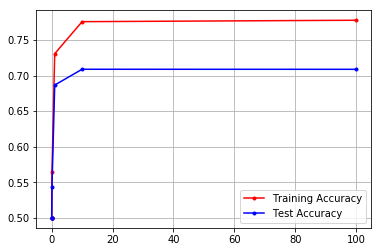

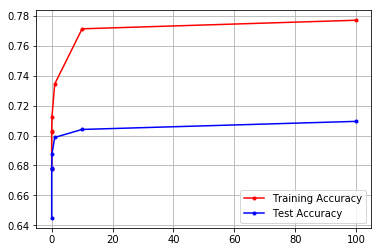

In [10]:
regularization = {
    'l1': 'Lasso',
    'l2': 'Ridge'
}

c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for key in regularization:
    print("Logistic Regression (Min-Max Scaled Data) with " + regularization[key])
    acc_training_mm = []
    acc_testing_mm = []
    for val in c_values:
        print("C:", val)
        acc_tr_mm, acc_te_mm = logreg_model_mm(c=val, penalty=key)
        acc_training_mm.append(acc_tr_mm)
        acc_testing_mm.append(acc_te_mm)
        print('Training accuracy:', acc_tr_mm)
        print('Testing accuracy:', acc_te_mm)
        print()
    plt.figure()
    plt.plot(c_values, acc_training_mm, 'r.-') 
    plt.plot(c_values, acc_testing_mm,'b.-') 
    plt.grid()
    plt.legend(['Training Accuracy', 'Test Accuracy'], loc='lower right')
    print()